<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/ecg_cnn_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d shayanfazeli/heartbeat

 98% 97.0M/98.8M [00:04<00:00, 31.4MB/s]
100% 98.8M/98.8M [00:04<00:00, 25.0MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/heartbeat.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight, resample
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input,  Softmax, Add,  AveragePooling1D, ZeroPadding1D,Activation
from keras import backend as K
from keras.models import Model
from keras.initializers import glorot_uniform

In [5]:
train_df=pd.read_csv('/content/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/mitbih_test.csv',header=None)

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_df.shape

(87554, 188)

In [8]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test_df.shape

(21892, 188)

In [10]:
train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [11]:
print(train_df[187].value_counts())

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64


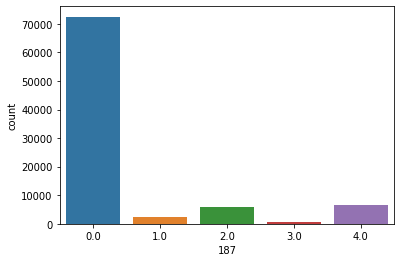

In [12]:
sns.countplot(x=187, data = train_df) 

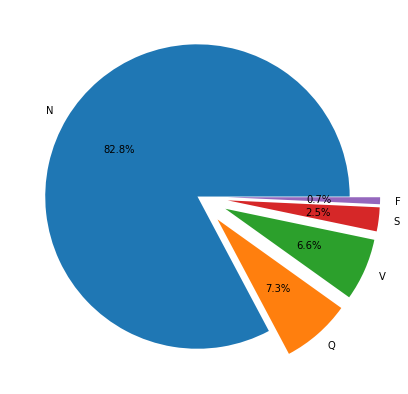

In [13]:
plt.figure(figsize=(7,7))
explode = (0, 0.2,0.2,0.2,0.2)
plt.pie(train_df[187].value_counts(), labels=['N','Q','V','S','F'], autopct='%1.1f%%', explode=explode)
plt.show()

In [14]:
x = train_df.drop(187,axis=1)
y = train_df[187].astype('int64')
print(x.shape)
print(y.shape)

(87554, 187)
(87554,)


In [15]:
x_train,x_val,y_train,y_val = train_test_split(x,y.values,random_state=42,stratify=y.values,shuffle=True,train_size=0.75)

In [16]:
print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)

The shape of training data :  (65665, 187) (65665,)
The shape of validation data :  (21889, 187) (21889,)


In [17]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)

x_val = scaler.transform(x_val)

In [18]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)


In [19]:
x_train = np.expand_dims(x_train, 2)
x_val = np.expand_dims(x_val, 2)

print("The shape of training data : ",x_train.shape,y_train.shape)
print("The shape of validation data : ",x_val.shape,y_val.shape)


The shape of training data :  (65665, 187, 1) (65665, 5)
The shape of validation data :  (21889, 187, 1) (21889, 5)


In [20]:
cnn = Sequential()
cnn.add(Conv1D(128,3,input_shape=(x_train.shape[1],1), activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,3, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,2, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Conv1D(64,2, activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(5, activation='softmax'))

In [21]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 185, 128)          512       
                                                                 
 batch_normalization (BatchN  (None, 185, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 92, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 90, 64)            24640     
                                                                 
 batch_normalization_1 (Batc  (None, 90, 64)           256       
 hNormalization)                                                 
                                                        

In [22]:
callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True)]

In [23]:
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
history=cnn.fit(x_train, y_train,epochs=20, callbacks=callbacks, batch_size=32, validation_data=(x_val,y_val))

Epoch 1/20
2053/2053 [==============================] - 132s 64ms/step - loss: 0.1855 - accuracy: 0.9499 - val_loss: 0.1057 - val_accuracy: 0.9717
Epoch 2/20
2053/2053 [==============================] - 125s 61ms/step - loss: 0.1122 - accuracy: 0.9701 - val_loss: 0.0833 - val_accuracy: 0.9778
Epoch 3/20
2053/2053 [==============================] - 137s 67ms/step - loss: 0.0913 - accuracy: 0.9748 - val_loss: 0.0753 - val_accuracy: 0.9796
Epoch 4/20
2053/2053 [==============================] - 132s 64ms/step - loss: 0.0776 - accuracy: 0.9781 - val_loss: 0.0792 - val_accuracy: 0.9772
Epoch 5/20
2053/2053 [==============================] - 124s 61ms/step - loss: 0.0697 - accuracy: 0.9802 - val_loss: 0.0646 - val_accuracy: 0.9825
Epoch 6/20
2053/2053 [==============================] - 126s 61ms/step - loss: 0.0633 - accuracy: 0.9816 - val_loss: 0.0584 - val_accuracy: 0.9835
Epoch 7/20
2053/2053 [==============================] - 123s 60ms/step - loss: 0.0568 - accuracy: 0.9831 - val_loss: 0

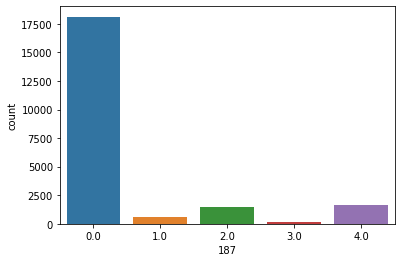

In [25]:
classes = []
sns.countplot(x=187, data = test_df)

In [26]:
print(test_df[187].value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64


In [27]:
class_1 = test_df[test_df[187]==1.0]
class_2 = test_df[test_df[187]==2.0]
class_3 = test_df[test_df[187]==3.0]
class_4 = test_df[test_df[187]==4.0]
class_0 = test_df[test_df[187]==0.0].sample(n = 1400)

class_1=resample(class_1, replace=True, n_samples=600, random_state=1)
#class_2=resample(class_2, replace=True, n_samples=2000, random_state=1)
class_3=resample(class_3, replace=True, n_samples=500, random_state=1)
#class_4=resample(class_4, replace=True, n_samples=2000, random_state=1)

In [28]:
new_test_df = pd.concat([class_0, class_1, class_2, class_3, class_4])

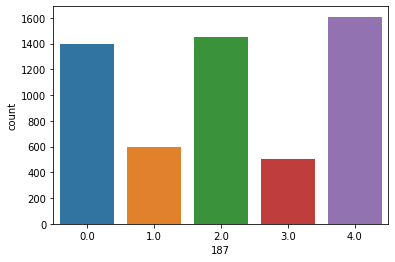

In [29]:
sns.countplot(x=187, data = new_test_df) 

In [30]:
x_test = new_test_df.drop(187,axis=1)
y_test = new_test_df[187].astype('int64')
print(x_test.shape)
print(y_test.shape)

(5556, 187)
(5556,)


In [31]:
x_test = scaler.transform(x_test)

In [32]:
y_test = tf.keras.utils.to_categorical(y_test)

In [33]:
x_test = np.expand_dims(x_test, 2)
print("The shape of testing data : ",x_test.shape,y_test.shape)

The shape of testing data :  (5556, 187, 1) (5556, 5)


In [34]:
from keras.models import load_model
best_model=load_model('best_weights.h5')
results = best_model.evaluate(x_test,y_test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

174/174 [==============================] - 3s 14ms/step - loss: 0.2730 - accuracy: 0.9222
Test Loss: 0.27301
Test Accuracy: 92.22%


In [35]:
results2 = cnn.evaluate(x_test,y_test, verbose=0)

print("     Test Loss: {:.5f}".format(results2[0]))
print(" Test Accuracy: {:.2f}%".format(results2[1] * 100))

     Test Loss: 0.30442
 Test Accuracy: 93.23%


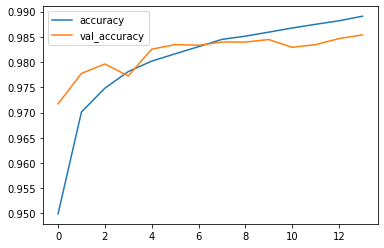

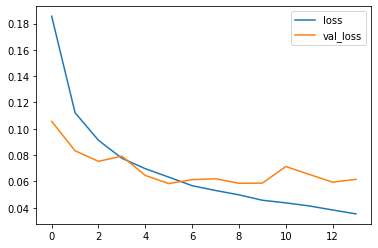

In [36]:
pd.DataFrame(history.history)
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

174/174 [==============================] - 3s 13ms/step


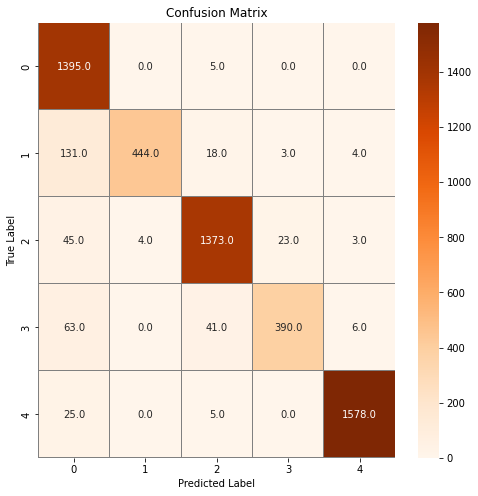

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = cnn.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [38]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1400
           1       0.99      0.74      0.85       600
           2       0.95      0.95      0.95      1448
           3       0.94      0.78      0.85       500
           4       0.99      0.98      0.99      1608

    accuracy                           0.93      5556
   macro avg       0.94      0.89      0.91      5556
weighted avg       0.94      0.93      0.93      5556



In [43]:
'''def create_vgg16_model():
    model = Sequential([
    # 1st Conv Block
        Conv1D (filters =64, kernel_size =3, padding ='same',input_shape=(x_train.shape[1],1), activation='relu'),
        Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 2nd Conv Block
        Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 3rd Conv block  
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # 4th Conv block
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),

    # 5th Conv block
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu'),
        MaxPooling1D(pool_size =2, strides =2, padding ='same'),
    
    # Fully connected layers  
        Flatten(),
        Dense(units = 4096, activation ='relu'),
        Dense(units = 4096, activation ='relu'), 
        Dense(units = 5, activation ='softmax')
    ])
    
    return model

vgg16_model = create_vgg16_model()
vgg16_model.summary()'''

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 187, 64)           256       
                                                                 
 conv1d_18 (Conv1D)          (None, 187, 64)           12352     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 94, 64)           0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, 94, 128)           24704     
                                                                 
 conv1d_20 (Conv1D)          (None, 94, 128)           49280     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 47, 128)          0         
 1D)                                                  

In [44]:
'''callbacks = [EarlyStopping(monitor='val_loss', patience=8), ModelCheckpoint(filepath='best_weights.h5', monitor='val_loss', save_best_only=True)]

In [1]:
'''vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
vgg16_history = vgg16_model.fit(x=x_train,y= y_train,batch_size=32, epochs=30,callbacks=callbacks, verbose=1, validation_data=(x_val, y_val), shuffle=True)'''

"vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\nvgg16_history = vgg16_model.fit(x=x_train,y= y_train,batch_size=32, epochs=30,callbacks=callbacks, verbose=1, validation_data=(x_val, y_val), shuffle=True)"

In [ ]:
'''from keras.models import load_model
best_model=load_model('best_weights.h5')
results = best_model.evaluate(x_test,y_test)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))'''

In [ ]:
'''results2 = vgg16_model.evaluate(x_test,y_test, verbose=0)

print("     Test Loss: {:.5f}".format(results2[0]))
print(" Test Accuracy: {:.2f}%".format(results2[1] * 100))'''

In [ ]:
'''pd.DataFrame(vgg16_history.history)
pd.DataFrame(vgg16_history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(vgg16_history.history)[['loss', 'val_loss']].plot()'''

In [ ]:
'''from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = vgg16_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()'''

In [ ]:
#print(classification_report(Y_true, Y_pred_classes))